In [1]:
#1D non-isothermal
#I think we should still convert it to molar flowrates somehow!!!

'''NEED TO REDO THE A/V CALCULATION AND CONFIRM THE JOULE HEATING EQUATION'''

from scipy.integrate import solve_bvp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#WANT TO RE-ARANGE CONSTANTS

#reactor constants
L = 0.0609 #m
R_inner = 2.39/1000 #m
R_outer = 3.5/1000 #m

A = np.pi * ((R_outer*100)**2-(R_inner*100)**2) #cm^2 MIGHT HAVE TO ADJUST THE AREA CALC A BIT
V = A*L/(100**2) #m^3
S = 2*np.pi*R_outer*L #m^2

h2Removal = 0 #change to 1 if there is removal of hydrogen

#gas flow constants
Tin = 622+273 #K
P = 1 #bar or atm

sccm0 = np.array([16.16, 48.48, 0, 0, 10, 5])
mols0 = sccm0/22400 * 60
y0 = mols0/sum(mols0)
y0 = np.concatenate((y0, [Tin]))
print(y0)

u0 = sum(sccm0) * 273 / Tin * P / 1 / 60 #cm^3/sec
v0 = u0 / A / 100 #m/sec

#rate equation constants
Rgas = 8.314 #J / mol·K
Easmr = 165.740 #kJ/mol
Asmr = 1.68*10**8
Eawgs = 89.23 #kJ/mol
Awgs = 9.90*10**3

Ku = 1

I = 9 #curent in Amps
F = 96485 #faradays constant

Cpg = 30 #J/mol·K

dHsmr = 206.1*10**3 #J/mol
dHwgs = -41.15*10**3 #J/mol

U = 0.116 #J (s K)^-1.
Ts = 298 #K

Iheat = 1
Resist = 15

[2.02913109e-01 6.08739327e-01 0.00000000e+00 0.00000000e+00
 1.25565043e-01 6.27825213e-02 8.95000000e+02]


In [3]:
x_num = 50

x_pts = np.linspace(0,L,x_num)

#initial guess array
init_guess = np.zeros((7, x_num))
init_guess[6, :] = Tin+5

init_guess[0, :] = 0.2
init_guess[1, :] = 0.6  
init_guess[2, :] = 0
init_guess[3, :] = 0    
init_guess[4, :] = 0.1

#what seems to me to be better guesses makes it worse

def odes(x, y): #dy/dt = f(x)
    #NEED TO ADJUST THIS. THESE ARE NOT CONCENTRATIONS, THEY ARE MOL FRACTIONS
    Cch4 = y[0]
    Ch2o = y[1]
    Cco = y[2]
    Cco2 = y[3]
    Ch2 = y[4]
    T = y[6]
    
    Keqsmr = (101325/100000)**2 * np.exp(-26830/T + 30.114)
    Keqwgs = np.exp(4400/T - 4.036)
    Ctot = P/(8.3144598 * 10**-5 * T)

    '''the velocity would also be dependent on the temperature'''
    v = v0*(3*y0[0] - 2*Cch4)/y0[0] # v0*(1+2X)
    # print(len(v))
    
    '''NEED TO REDO THE A/V CALCULATION'''
    rsmr = 2/R_outer*Ku*Asmr*np.exp(-Easmr*1000/Rgas/T)*(Cch4*Ch2o-(P**2)*Cco*(Ch2**3)/Keqsmr)/Ctot
    rwgs = 2/R_outer*Ku*Awgs*np.exp(-Eawgs*1000/Rgas/T)*(Ch2o*Cco-Cco2*Ch2/Keqwgs)/Ctot
    rh2r = I/(2*F*L)/Ctot #have not confirmed if this is correct

    ch4 = (-rsmr)/v
    h2o = (-rsmr - rwgs)/v
    co = (rsmr - rwgs)/v
    co2 = (rwgs)/v
    h2 = (3*rsmr + rwgs + h2Removal*rh2r)/v
    ar = np.zeros(len(Cch4))
    #constant heats of reaction, estimated and constant heat capacities, no joule heating, WANT TO UNDERSTAND THE JOULE HEATING MORE
    Temp = (S*U*(-T[:] + Ts) - S*(dHsmr*rsmr + dHwgs*rwgs) + Iheat**2 * Resist)/(v*Ctot*Cpg*V)
    
    return np.vstack([ch4, h2o, co, co2, h2, ar, Temp])

def bcs(yleft, yright):
    return np.array(yleft-y0)   #ADD THE TEMPERATURE IN y0 BX ALSO NEEDS TO BE BC

soln = solve_bvp(odes, bcs, x_pts, init_guess, max_nodes=100, tol = 0.0001)

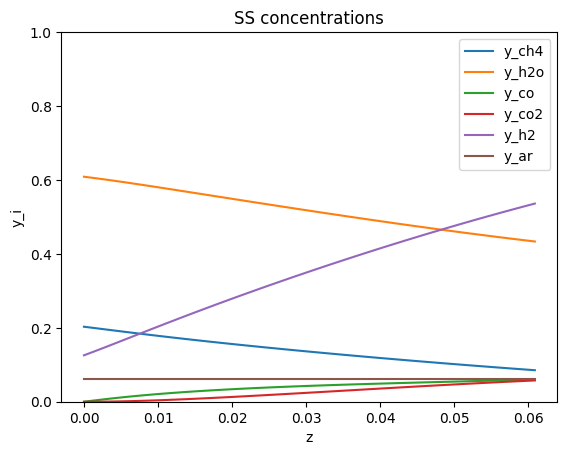

In [4]:
plt.plot(soln.x, soln.y[0], label='y_ch4')
plt.plot(soln.x, soln.y[1], label='y_h2o')
plt.plot(soln.x, soln.y[2], label='y_co')
plt.plot(soln.x, soln.y[3], label='y_co2')
plt.plot(soln.x, soln.y[4], label='y_h2')
plt.plot(soln.x, soln.y[5], label='y_ar')
plt.ylim(0, 1)
plt.xlabel('z')
plt.ylabel('y_i')
plt.title('SS concentrations')
plt.legend()

Text(0.5, 1.0, 'Temperature profile')

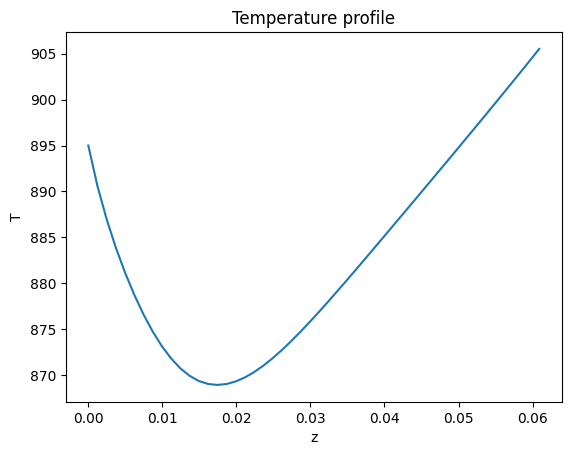

In [5]:
plt.plot(soln.x, soln.y[6])
plt.xlabel('z')
plt.ylabel('T')
plt.title('Temperature profile')